In [1]:
import jax.random
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import jax.numpy as jnp
import jax.random as random
import tensorflow_probability.substrates.jax as tfp
import optax
tfd = tfp.distributions
%load_ext autoreload

%cd /mnt/c/Users/Habush/PycharmProjects/bnn_bg

2023-12-29 13:27:54.882617: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


/mnt/c/Users/Habush/PycharmProjects/bnn_bg


In [112]:
%autoreload
from core.sgmcmc import *
import operator
def get_discrete_kernel(seed, step_size_fn, log_prob_fn, optimizer_fn, 
                        x0, mh=False, 
                        temp=1.0, preconditioner=None, 
                        cat=False, dim=None, num_cls=None):
    
    if cat:
        sampler = optimizer_fn(step_size_fn, seed, dim, num_cls,
                              preconditioner=preconditioner, mh=mh, temp=temp)
    else:
        sampler = optimizer_fn(step_size_fn, seed, 
                          preconditioner=preconditioner, mh=mh, temp=temp)
    opt_state = sampler.init(x0)
    
    def step(z, state, opt_state):
        def lp_fn(x):
            return log_prob_fn(x, state)
        
        z, opt_state, accept_prob = sampler.update(z, lp_fn, opt_state)
        return z, opt_state, {"accept_prob": accept_prob}
    
    return step, opt_state

def get_continuous_kernel(seed, step_size_fn, log_prob_fn, optimizer_fn,
                          x0, mh=False,
                          preconditioner=get_rmsprop_preconditioner(), momentum=0.9):
    
    sampler = optimizer_fn(step_size_fn, seed, preconditioner=preconditioner, momentum_decay=momentum)
    init_opt_state = sampler.init(x0)
    
    def proposal_dist(x_new, x_prev, state, step_size):
        grad = jax.grad(log_prob_fn)(x_prev, state)
        theta = x_new - x_prev - step_size*grad
        # theta_dot = jnp.linalg.norm(theta)**2
        theta_dot = jax.tree_util.tree_reduce(
            operator.add, jax.tree_util.tree_map(lambda x: jnp.sum(x * x), theta))

        return -0.25*(1.0 / step_size) * theta_dot
    
    def step(x, state, opt_state):
        grad = jax.grad(log_prob_fn)(x, state)
        updates, opt_state = sampler.update(grad, opt_state)
        x_new = optax.apply_updates(x, updates)
        accept_prob = 1.0 #default in the unadjusted case where mh=False
        accepted = True
        if mh:
            step_size = step_size_fn(opt_state.count - 1) #minus 1 b/c the count has been incremented in the update
            q_forward = proposal_dist(x_new, x, state, step_size)
            log_prob_x = log_prob_fn(x, state)
            q_reverse = proposal_dist(x, x_new, state, step_size)
            log_prob_x_new = log_prob_fn(x_new, state)

            m = (log_prob_x_new - log_prob_x) + (q_reverse - q_forward)
            delta = jnp.exp(m)
            delta = jnp.where(jnp.isnan(delta), -jnp.inf, delta)
            accept_prob = jnp.clip(delta, a_max=1.0)
            u = jax.random.uniform(opt_state.rng_key)
            accepted = accept_prob > u

            # x_new = x_new if accepted else x #accept/reject
            x_new = jnp.where(accepted, x_new, x)
        return x_new, opt_state, {"accepted": accepted, "accept_prob": accept_prob}
    
    return step, init_opt_state

CUDA backend failed to initialize: Unable to load CUDA. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


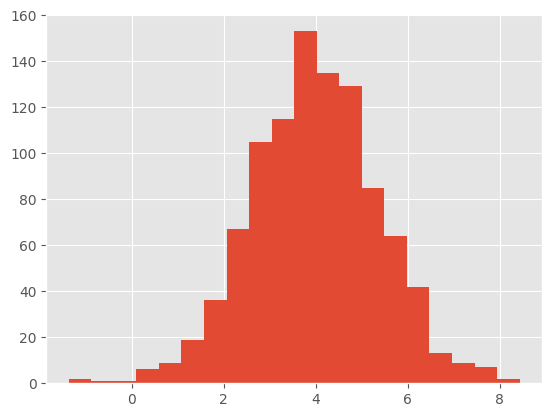

In [4]:
seed = 0
rng = random.PRNGKey(seed)
mean = 4.0
sigma = 2.0
gaus_dist = tfd.Normal(mean, jnp.sqrt(sigma))
N = 1000
samples_gaus_1d = gaus_dist.sample(seed=rng, sample_shape=(N,))
plt.hist(samples_gaus_1d, bins=20)
plt.show()

In [5]:
def log_prob_mu(x, mu_0, sigma_0):
    n = x.shape[0]
    
    def log_prob_fn(mu, state):
        sigma = state["sigma"]
        sigma = jax.nn.softplus(sigma)
        x_bar = jnp.mean(x)
        first_term = (sigma / (n*sigma_0 + sigma))*mu_0
        second_term = (n*sigma_0 / (n*sigma_0 + sigma))*x_bar
        
        mu_n = first_term + second_term
        
        sigma_inv = (1/sigma_0) + (n/sigma)
        sigma_n = 1/sigma_inv
        log_prob = tfd.Normal(mu_n, jnp.sqrt(sigma_n)).log_prob(mu)
        return log_prob
    
    return log_prob_fn


def log_prob_sigma(x, a_0, b_0):
        n = x.shape[0]
        
        def log_prob_fn(sigma, state):
            mu = state["mu"]
            sigma = jax.nn.softplus(sigma)
            
            a_n = a_0 + n/2
            b_n = b_0 + 0.5*jnp.sum((x - mu)**2)
        
            log_prob = tfd.InverseGamma(a_n, b_n).log_prob(sigma)
            return log_prob
        
        return log_prob_fn

In [6]:
import functools
from tqdm import tqdm

def gibbs_sampler_1d(*, seed, data, step_sizes,
                  a_0, b_0, mu_0, sigma_0, mh=False,
                  n_iters=10000, burn_in=1000, show_progress=True):
    
    rng = random.PRNGKey(seed)
    init_key, key = random.split(rng, 2)
    
    mu_key, sigma_key = jax.random.split(init_key, 2)
    
    n = data.shape[0]
    
    mu0 = tfd.Normal(mu_0, jnp.sqrt(sigma_0)).sample(seed=mu_key)
    sigma0 = tfd.Gamma(a_0, b_0).sample(seed=sigma_key)
    
    mu_log_prob_fn = log_prob_mu(data, mu_0, sigma_0)
    sigma_log_prob_fn = log_prob_sigma(data, a_0, b_0)
    
    mu_kernel, mu_opt_state = get_continuous_kernel(seed, optax.constant_schedule(step_sizes["mu"]), mu_log_prob_fn,
                                      sgld_gradient_update, mu0, mh=mh)
    
    sigma_kernel, sigma_opt_state = get_continuous_kernel(seed, optax.constant_schedule(step_sizes["sigma"]), sigma_log_prob_fn,
                                      sgld_gradient_update, sigma0, mh=mh)
    

    mu_kernel = jax.jit(mu_kernel)
    sigma_kernel = jax.jit(sigma_kernel)
    
    state = {"mu": mu0,  "sigma": sigma0}
    samples = {k: [] for k in state.keys()}
    
    accept_probs = {"mu": np.zeros((n_iters)), "sigma": np.zeros(n_iters)}
    
    for k, v in state.items():
        samples[k].append(v)
        
    if show_progress:
        iterator = tqdm(range(n_iters))
    else:
        iterator = range(n_iters)

    for i in iterator:
        mu, mu_opt_state, mu_mh_info = mu_kernel(state["mu"], state, mu_opt_state)
        sigma, sigma_opt_state, sigma_mh_info = sigma_kernel(state["sigma"], state, sigma_opt_state)
        state = {"mu": mu,  "sigma": sigma}
        accept_probs["mu"][i] = mu_mh_info["accept_prob"]
        accept_probs["sigma"][i] = sigma_mh_info["accept_prob"]
        if i > burn_in:
            for k, v in state.items():
                samples[k].append(v)
        
    return samples, accept_probs

In [7]:
step_sizes = {"mu": 0.1, "sigma": 0.1}
a_0, b_0 = 1.0, 1.0
mu_0 = -2.0
sigma_0 = 5.0
samples, accept_probs = gibbs_sampler_1d(seed=seed, data=samples_gaus_1d, step_sizes=step_sizes, 
                        a_0=a_0, b_0=b_0, mu_0=mu_0, sigma_0=sigma_0, mh=True,
                        n_iters=2000, burn_in=1000, show_progress=True)

print(f"Acceptance probs - mu: {accept_probs['mu'].mean()}, sigma: {accept_probs['sigma'].mean()}")

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 3348.86it/s]

Acceptance probs - mu: 0.09388478956596474, sigma: 0.36952958149037685


In [8]:
accept_probs["sigma"].mean()

0.36952958149037685

In [9]:
np.mean(samples["mu"])

3.9980733

In [10]:
jnp.mean(jax.nn.softplus(jnp.array(samples["sigma"])))

Array(1.8575451, dtype=float32)

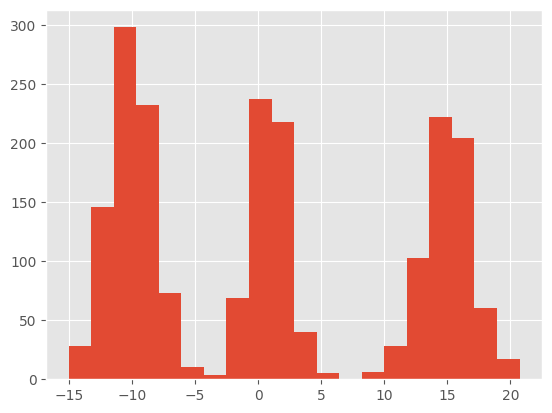

In [85]:
seed = 42
rng = random.PRNGKey(seed)
means = jnp.array([-10.0, 1.0, 15.0])
sigma = jnp.array([3.0, 2.0, 4.0])
# weights = jnp.array([0.6, 0.4])
weights = jnp.array([0.4, 0.3, 0.3])
gmm_dist = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=weights),
    components_distribution=tfd.Normal(
        loc=means,
        scale=jnp.sqrt(sigma)))
N = 2000
samples_1d = gmm_dist.sample(seed=rng, sample_shape=(N,))
plt.hist(samples_1d, bins=20)
plt.show()

In [86]:
EPS = 1e-12
from tensorflow_probability.python.internal.backend.jax.compat import v2 as tf
import scipy.stats as stats
bij = tfp.bijectors

def get_log_prob_z(x) :
    def get_per_comp_log_p(xi, pi_k, mu_k, sigma_k):
        logp = tfd.Normal(mu_k, jnp.sqrt(sigma_k)).log_prob(xi)
        return logp + jnp.log(pi_k + EPS)
    
    def log_prob_fn(z, state):
        pi = state["pi"]
        mu, sigma = state["mu"], state["sigma"]
        pi = jax.nn.softmax(pi, axis=-1)
        sigma = 1./jax.nn.softplus(sigma)
        logits = jax.vmap(lambda i: jax.vmap(get_per_comp_log_p, 
                                             in_axes=(None, 0, 0, 0))(i, pi, mu, sigma))(x)
        log_prob = jax.vmap(lambda i, k: -tf.nn._softmax_cross_entropy_with_logits(logits=i, labels=k))(logits, z)
        return jnp.sum(log_prob)
    
    return log_prob_fn

def get_log_prob_pi(alpha, num_comps):
    def get_concentrations(k, z):
        idx = jax.nn.one_hot(z, num_comps) == jax.nn.one_hot(k, num_comps)
        idx_k = jnp.sum(idx, axis=-1) == num_comps
        n_k = jnp.sum(idx_k)
        alpha_k = alpha[k]
        return (alpha_k + n_k) / num_comps
    
    def log_prob_fn(pi, state):
        z = state["z"]
        concentrations = jax.vmap(get_concentrations, in_axes=(0, None))(jnp.arange(num_comps), z)
        log_probs = tfd.Dirichlet(concentrations).log_prob(jax.nn.softmax(pi, axis=-1))
        return log_probs
    
    return log_prob_fn

def get_log_prob_mu(x, mu_0, sigma_0, num_comps):
    
    def get_per_comp_log_p(k, mu_k, sigma_k, z):
        idx = jax.nn.one_hot(z, num_comps) == jax.nn.one_hot(k, num_comps)
        idx_k = jnp.sum(idx, axis=-1) == num_comps
        n_k = jnp.sum(idx_k)
        x_bar_k =  jnp.sum(jnp.where(idx_k, x, 0)) / jnp.where(n_k > 0, n_k, 1.)
        first_term = (sigma_k / (n_k*sigma_0[k] + sigma_k))*mu_0
        second_term = (n_k*sigma_0[k] / (n_k*sigma_0[k] + sigma_k))*x_bar_k
        
        mu_n = first_term + second_term
        
        sigma_inv = (1/sigma_0[k]) + (n_k/sigma_k)
        sigma_n = 1/sigma_inv
        log_prob = tfd.Normal(mu_n, jnp.sqrt(sigma_n)).log_prob(mu_k)
        return log_prob
    
    def log_prob_fn(mu, state):
        sigma = state["sigma"]
        z = state["z"]
        sigma = 1./jax.nn.softplus(sigma)
        log_probs = jax.vmap(get_per_comp_log_p, in_axes=(0, 0, 0, None))(jnp.arange(num_comps), mu, sigma, z)
        return jnp.sum(log_probs)
    
    return log_prob_fn

def get_log_prob_sigma(x, a_0, b_0, num_comps):

        def get_per_comp_log_p(k, prec_k, mu_k, z):
            idx = jax.nn.one_hot(z, num_comps) == jax.nn.one_hot(k, num_comps)
            idx_k = jnp.sum(idx, axis=-1) == num_comps
            n_k = jnp.sum(idx_k)
            a_k = a_0[k] + n_k/2
            rss = jnp.sum((idx_k*(x - mu_k)**2))
            b_k = b_0[k] + rss/2
            log_p = tfd.Gamma(a_k, b_k).log_prob(prec_k)
            return log_p


        def log_prob_fn(sigma, state):
            z = state["z"]
            mu = state["mu"]
            precision = 1./jax.nn.softplus(sigma) # work with the precision
            log_probs = jax.vmap(get_per_comp_log_p, in_axes=(0, 0, 0, None))(jnp.arange(num_comps), precision, mu, z)
            return jnp.sum(log_probs)

        return log_prob_fn

# def get_log_prob_sigma(x, a_0, b_0, mu_0, sigma_0,
#                        num_comps):
#         
#         mu_log_prob_fn = get_log_prob_mu(x, mu_0, sigma_0, num_comps)
#         
#         def get_per_comp_log_p(k, prec_k, mu_k, z):
#             idx = jax.nn.one_hot(z, num_comps) == jax.nn.one_hot(k, num_comps)
#             idx_k = jnp.sum(idx, axis=-1) == num_comps
#             n_k = jnp.sum(idx_k)
#             a_k = a_0[k] + n_k/2
#             rss = jnp.sum((idx_k*(x - mu_k)**2))
#             b_k = b_0[k] + rss/2
#             log_p = tfd.Gamma(a_k, b_k).log_prob(prec_k)
#             return log_p
# 
#         
#         def log_prob_fn(sigma, state):
#             z = state["z"]
#             mu = state["mu"]
#             sigma = jax.nn.softplus(sigma)
#             log_probs1 = tfd.HalfCauchy(a_0, b_0).log_prob(sigma)
#             
#             return jnp.sum(log_probs)
#         
#         return log_prob_fn


In [146]:
import functools
from tqdm import tqdm

def gibbs_sampler_gmm_1d(*, seed, data, step_sizes, num_components,
                  a_0, b_0, mu_0, sigma_0, alpha, mh=False,
                  n_iters=10000, burn_in=1000, show_progress=True):
    
    rng = random.PRNGKey(seed)
    init_key, key = random.split(rng, 2)
    
    z_key, pi_key, mu_key, sigma_key = jax.random.split(init_key, 4)
    
    k, n = num_components, data.shape[0]
    
    pi0 = alpha / k
    z0 = tfd.Categorical(probs=pi0).sample(seed=z_key, sample_shape=(n,))
    mu0 = tfd.Normal(mu_0, jnp.sqrt(sigma_0)).sample(seed=mu_key)
    sigma0 = tfd.InverseGamma(a_0, b_0).sample(seed=sigma_key)
    
    
    z_log_prob_fn = get_log_prob_z(data)
    mu_log_prob_fn = get_log_prob_mu(data, mu_0, sigma_0, num_components)
    pi_log_prob_fn = get_log_prob_pi(alpha, num_components)
    sigma_log_prob_fn = get_log_prob_sigma(data, a_0, b_0, k)
    
    z_kernel_no_mh, z_opt_state_no_mh = get_discrete_kernel(seed, optax.constant_schedule(step_sizes["z"]), 
                                                        z_log_prob_fn, disc_cat_sgld_gradient_update, z0[:,None],
                                                         dim=1, num_cls=num_components, cat=True, mh=False)
    
    z_kernel_mh, z_opt_state_mh = get_discrete_kernel(seed, optax.constant_schedule(step_sizes["z"]), z_log_prob_fn,
                                   disc_cat_sgld_gradient_update, z0[:,None],
                                   dim=1, num_cls=num_components, cat=True, mh=True)
    
    pi_kernel_no_mh, pi_opt_state_no_mh = get_continuous_kernel(seed, optax.constant_schedule(step_sizes["pi"]), 
                                                         pi_log_prob_fn, sgld_gradient_update, pi0, mh=False)
    
    pi_kernel_mh, pi_opt_state_mh = get_continuous_kernel(seed, optax.constant_schedule(step_sizes["pi"]), 
                                                          pi_log_prob_fn, sgld_gradient_update, pi0, mh=True)
    
    mu_kernel_no_mh, mu_opt_state_no_mh = get_continuous_kernel(seed, optax.constant_schedule(step_sizes["mu"]), 
                                                         mu_log_prob_fn, sgld_gradient_update, mu0, mh=False)
    
    mu_kernel_mh, mu_opt_state_mh = get_continuous_kernel(seed, optax.constant_schedule(step_sizes["mu"]), 
                                                          mu_log_prob_fn, sgld_gradient_update, mu0, mh=True)
    
    sigma_kernel_no_mh, sigma_opt_state_no_mh = get_continuous_kernel(seed, optax.constant_schedule(step_sizes["sigma"]), sigma_log_prob_fn,
                                      sgld_gradient_update, sigma0, mh=False)
    
    sigma_kernel_mh, sigma_opt_state_mh = get_continuous_kernel(seed, optax.constant_schedule(step_sizes["sigma"]), 
                                                           sigma_log_prob_fn, sgld_gradient_update, sigma0, mh=True)
    
    z_kernel_no_mh = jax.jit(z_kernel_no_mh)
    z_kernel_mh = jax.jit(z_kernel_mh)
    pi_kernel_no_mh = jax.jit(pi_kernel_no_mh)
    pi_kernel_mh = jax.jit(pi_kernel_mh)
    mu_kernel_no_mh = jax.jit(mu_kernel_no_mh)
    mu_kernel_mh = jax.jit(mu_kernel_mh)
    sigma_kernel_no_mh = jax.jit(sigma_kernel_no_mh)
    sigma_kernel_mh = jax.jit(sigma_kernel_mh)
    
    z_kernel = z_kernel_no_mh
    pi_kernel = pi_kernel_no_mh
    mu_kernel = mu_kernel_no_mh
    sigma_kernel = sigma_kernel_no_mh
    
    z_opt_state = z_opt_state_no_mh
    pi_opt_state = pi_opt_state_no_mh
    mu_opt_state = mu_opt_state_no_mh
    sigma_opt_state = sigma_opt_state_no_mh
    
    switch_to_mh = False
    
    
    state = {"pi": pi0, "z": z0, "mu": mu0,  "sigma": sigma0}
    samples = {k: [] for k in state.keys()}
    
    accept_probs = {"pi": np.zeros((n_iters)), "mu": np.zeros(n_iters), "sigma": np.zeros(n_iters), 
                    "z": np.zeros(n_iters)}
    
    for k, v in state.items():
        samples[k].append(v)
        
    # sigma = jnp.array([1.0, 2.0, 1.0])
    if show_progress:
        iterator = tqdm(range(n_iters))
    else:
        iterator = range(n_iters)
    for i in iterator:
        if i > burn_in and mh and not switch_to_mh:
            z_kernel = z_kernel_mh
            pi_kernel = pi_kernel_mh
            mu_kernel = mu_kernel_mh
            sigma_kernel = sigma_kernel_mh
            
            # z_opt_state = z_opt_state_mh
            # pi_opt_state = pi_opt_state_mh
            # mu_opt_state = mu_opt_state_mh
            # sigma_opt_state = sigma_opt_state_mh
            
            switch_to_mh = True
        
        
        z, z_opt_state, z_mh_info = z_kernel(state["z"][:,None], state, z_opt_state)
        z = z.squeeze()
        pi, pi_opt_state, pi_mh_info = pi_kernel(state["pi"], state, pi_opt_state)
        mu, mu_opt_state, mu_mh_info = mu_kernel(state["mu"], state, mu_opt_state)
        sigma, sigma_opt_state, sigma_mh_info = sigma_kernel(state["sigma"], state, sigma_opt_state)
        
        state = {"pi": pi, "z": z, "mu": mu,  "sigma": sigma}
        
        #update accept probs
        accept_probs["pi"][i] = pi_mh_info["accept_prob"]
        accept_probs["mu"][i] = mu_mh_info["accept_prob"]
        accept_probs["sigma"][i] = sigma_mh_info["accept_prob"]
        accept_probs["z"][i] = z_mh_info["accept_prob"]
        
        if i > burn_in:
            for k, v in state.items():
                samples[k].append(v)
        
    return samples, accept_probs

In [114]:
step_sizes = {"z": 0.1, "pi": 0.1, "mu": 0.1, "sigma": 0.1}
k = len(weights)
a_0, b_0 = jnp.ones(k), jnp.ones(k)
mu_0 = random.uniform(key=random.PRNGKey(seed), shape=(k,), minval=-20, maxval=20)
sigma_0 = 5*jnp.ones(k)
alpha = jnp.ones(k)
samples, accept_probs = gibbs_sampler_gmm_1d(seed=0, data=samples_1d, step_sizes=step_sizes, 
                        num_components=k, a_0=a_0, b_0=b_0, mu_0=mu_0, sigma_0=sigma_0, 
                        alpha=alpha, mh=True,
                        n_iters=2000, burn_in=1000, show_progress=True)

#print mean accept probs
print(f"Acceptance probs - mu: {accept_probs['mu'].mean()}, sigma: {accept_probs['sigma'].mean()}, pi: {accept_probs['pi'].mean()}, z: {accept_probs['z'].mean()}")

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 372.21it/s]

Acceptance probs - mu: 0.501, sigma: 0.5945262250487856, pi: 0.5005, z: 0.9110000000156209


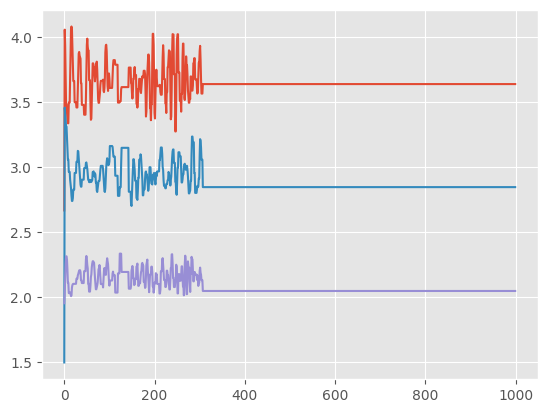

In [101]:
plt.plot(jax.nn.softplus(np.array(samples["sigma"])))
plt.show()

In [102]:
jnp.mean(jax.nn.softmax(jnp.array(samples["pi"]), axis=-1), axis=0)

Array([0.29579493, 0.40465462, 0.29955053], dtype=float32)

In [103]:
jnp.mean(jnp.array(samples["mu"]), axis=0)

Array([ 15.039443 , -10.091795 ,   0.9442762], dtype=float32)

In [104]:
jnp.mean(jax.nn.softplus(jnp.array(samples["sigma"])), axis=0)

Array([3.6457608, 2.8810596, 2.078937 ], dtype=float32)


### 2D distribution

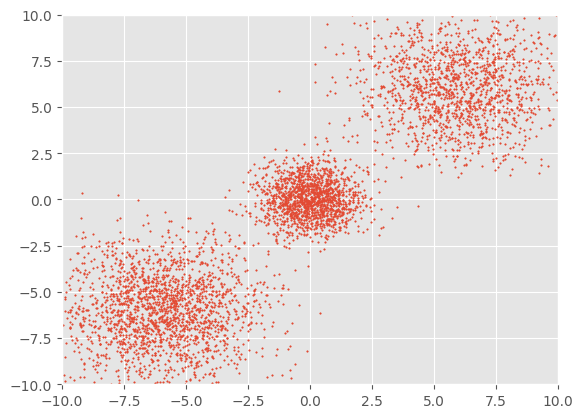

In [115]:
weights = jnp.array([0.4, 0.3, 0.3])
# weights = jnp.array([0.5, 0.2, 0.3])
# Number of training samples
num_samples = 5000
dtype = np.float32
# Ground truth loc values which we will infer later on. The scale is 1.
true_loc = jnp.array([[-6, -6],
                     [0, 0],
                     [6, 6]], dtype)

true_scale = jnp.array([[2.0, 2.0], 
                        [1.0, 1.0], 
                        [2.0, 2.0]])

true_components_num, dims = true_loc.shape

# Generate training samples from ground truth loc
# true_hidden_component = random.randint(rng, shape=(num_samples,), minval=0, maxval=true_components_num)
# observations = true_loc[true_hidden_component] + random.normal(rng, shape=(num_samples, dims))
gmm_dist = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=weights),
        components_distribution=tfd.MultivariateNormalDiag(
            loc=true_loc, scale_diag=true_scale))
observations = gmm_dist.sample(seed=rng, sample_shape=(num_samples,))
# Visualize samples
plt.scatter(observations[:, 0], observations[:, 1], 1)
plt.axis([-10, 10, -10, 10])
plt.show()

In [136]:
EPS = 1e-12
from tensorflow_probability.python.internal.backend.jax.compat import v2 as tf

def get_log_prob_z_nd(x) :
    def get_per_comp_log_p(xi, pi_k, mu_k, sigma_k):
        logp = tfd.MultivariateNormalFullCovariance(mu_k, jnp.diag(sigma_k)).log_prob(xi)
        return logp + jnp.log(pi_k + EPS)
    
    def log_prob_fn(z, state):
        pi = state["pi"]
        mu, sigma = state["mu"], state["sigma"]
        pi = jax.nn.softmax(pi, axis=-1)
        sigma = 1./jax.nn.softplus(sigma)
        logits = jax.vmap(lambda i: jax.vmap(get_per_comp_log_p, 
                                             in_axes=(None, 0, 0, 0))(i, pi, mu, sigma))(x)
        log_prob = jax.vmap(lambda i, k: -tf.nn._softmax_cross_entropy_with_logits(logits=i, labels=k))(logits, z)
        return jnp.sum(log_prob)
    
    return log_prob_fn

def get_log_prob_mu_nd(x, mu_0, sigma_0, num_comps):
    
    def get_per_comp_log_p(k, m, sigma_k, z):
        idx = jax.nn.one_hot(z, num_comps) == jax.nn.one_hot(k, num_comps)
        idx_k = jnp.sum(idx, axis=-1) == num_comps
        n_k = jnp.sum(idx_k)
        x_k =  jnp.sum(jnp.where(idx_k[:,None], x, 0), axis=0) / jnp.where(n_k > 0, n_k, 1.)
        v_0_k = jnp.diag(sigma_0[k])
        sigma_k = jnp.diag(sigma_k)
        v_0_inv = jnp.linalg.inv(v_0_k)
        sigma_k_inv = jnp.linalg.inv(sigma_k)
        
        v_k_inv = v_0_inv + n_k*sigma_k_inv
        v_k = jnp.linalg.inv(v_k_inv)
        
        m_k = v_k @ (sigma_k_inv@(n_k*x_k) + mu_0[k]*v_0_inv)
        log_p = tfd.MultivariateNormalFullCovariance(m_k, v_k).log_prob(m)
        return log_p
    
    def log_prob_fn(mu, state):
        sigma = state["sigma"]
        z = state["z"]
        sigma = 1./jax.nn.softplus(sigma)
        log_probs = jax.vmap(get_per_comp_log_p, in_axes=(0, 0, 0, None))(jnp.arange(num_comps), mu, sigma, z)
        return jnp.sum(log_probs)
    
    return log_prob_fn

def get_log_prob_sigma_nd(x, a_0, b_0, num_comps):
        
        def get_per_comp_log_p(k, sigma_k, mu_k, z):
            idx = jax.nn.one_hot(z, num_comps) == jax.nn.one_hot(k, num_comps)
            idx_k = jnp.sum(idx, axis=-1) == num_comps
            n_k = jnp.sum(idx_k)
            a_k = a_0[k] + n_k/2
            # print(f"x_k: {x.shape}, mu_k: {mu_k.shape}, idx_k: {idx_k.shape}")
            rss = jnp.sum((idx_k[:,None]*(x - mu_k)**2))
            b_k = b_0[k] + rss/2
            log_p = tfd.Gamma(a_k, b_k).log_prob(sigma_k)
            # print(f"a_k: {a_k.shape}, b_k: {b_k.shape}, log_p: {log_p.shape}")
            return jnp.sum(log_p)

        
        def log_prob_fn(sigma, state):
            z = state["z"]
            mu = state["mu"]
            sigma = 1./jax.nn.softplus(sigma)
            log_probs = jax.vmap(get_per_comp_log_p, in_axes=(0, 0, 0, None))(jnp.arange(num_comps), sigma, mu, z)
            return jnp.sum(log_probs)
        
        return log_prob_fn

In [137]:
from tqdm import tqdm
def gibbs_sampler_2d(*, seed, data, step_sizes, num_components, mu_0, v_0, alpha,         
                  mh=False, n_iters=10000, burn_in=1000):
    
    rng = random.PRNGKey(seed)
    init_key, key = random.split(rng, 2)
    
    z_key, pi_key, mu_key, sigma_key = jax.random.split(init_key, 4)
    
    k, n = num_components, data.shape[0]
    
    pi0 = alpha / k
    z0 = tfd.Categorical(probs=pi0).sample(seed=z_key, sample_shape=(n,))
    mu0 = tfd.MultivariateNormalDiag(mu_0, jnp.sqrt(v_0)).sample(seed=mu_key)
    sigma0 = tfd.InverseGamma(a_0, b_0).sample(seed=sigma_key)
    sigma0 = v_0
    
    z_log_prob_fn = get_log_prob_z_nd(data)
    mu_log_prob_fn = get_log_prob_mu_nd(data, mu_0, v_0, num_components)
    pi_log_prob_fn = get_log_prob_pi(alpha, num_components)
    sigma_log_prob_fn = get_log_prob_sigma_nd(data, a_0, b_0, num_components)
    
    z_kernel_no_mh, z_opt_state_no_mh = get_discrete_kernel(seed, optax.constant_schedule(step_sizes["z"]), 
                                                        z_log_prob_fn, disc_cat_sgld_gradient_update, z0[:,None],
                                                         dim=1, num_cls=num_components, cat=True, mh=False)
    
    z_kernel_mh, z_opt_state_mh = get_discrete_kernel(seed, optax.constant_schedule(step_sizes["z"]), z_log_prob_fn,
                                   disc_cat_sgld_gradient_update, z0[:,None],
                                   dim=1, num_cls=num_components, cat=True, mh=True)
    
    pi_kernel_no_mh, pi_opt_state_no_mh = get_continuous_kernel(seed, optax.constant_schedule(step_sizes["pi"]), 
                                                         pi_log_prob_fn, sgld_gradient_update, pi0, mh=False)
    
    pi_kernel_mh, pi_opt_state_mh = get_continuous_kernel(seed, optax.constant_schedule(step_sizes["pi"]), 
                                                          pi_log_prob_fn, sgld_gradient_update, pi0, mh=True)
    
    mu_kernel_no_mh, mu_opt_state_no_mh = get_continuous_kernel(seed, optax.constant_schedule(step_sizes["mu"]), 
                                                         mu_log_prob_fn, sgld_gradient_update, mu0, mh=False)
    
    mu_kernel_mh, mu_opt_state_mh = get_continuous_kernel(seed, optax.constant_schedule(step_sizes["mu"]), 
                                                          mu_log_prob_fn, sgld_gradient_update, mu0, mh=True)
    
    sigma_kernel_no_mh, sigma_opt_state_no_mh = get_continuous_kernel(seed, optax.constant_schedule(step_sizes["sigma"]), sigma_log_prob_fn,
                                      sgld_gradient_update, sigma0, mh=False)
    
    sigma_kernel_mh, sigma_opt_state_mh = get_continuous_kernel(seed, optax.constant_schedule(step_sizes["sigma"]), 
                                                           sigma_log_prob_fn, sgld_gradient_update, sigma0, mh=True)
    
    z_kernel_no_mh = jax.jit(z_kernel_no_mh)
    z_kernel_mh = jax.jit(z_kernel_mh)
    pi_kernel_no_mh = jax.jit(pi_kernel_no_mh)
    pi_kernel_mh = jax.jit(pi_kernel_mh)
    mu_kernel_no_mh = jax.jit(mu_kernel_no_mh)
    mu_kernel_mh = jax.jit(mu_kernel_mh)
    sigma_kernel_no_mh = jax.jit(sigma_kernel_no_mh)
    sigma_kernel_mh = jax.jit(sigma_kernel_mh)
    
    z_kernel = z_kernel_no_mh
    pi_kernel = pi_kernel_no_mh
    mu_kernel = mu_kernel_no_mh
    sigma_kernel = sigma_kernel_no_mh
    
    z_opt_state = z_opt_state_no_mh
    pi_opt_state = pi_opt_state_no_mh
    mu_opt_state = mu_opt_state_no_mh
    sigma_opt_state = sigma_opt_state_no_mh
    
    switch_to_mh = False
    state = {"pi": pi0, "z": z0, "mu": mu0,  "sigma": sigma0}
    samples = {k: [] for k in state.keys()}
    for k, v in state.items():
        samples[k].append(v)
    
    accept_probs = {"pi": np.zeros((n_iters)), "mu": np.zeros(n_iters), "sigma": np.zeros(n_iters), 
                    "z": np.zeros(n_iters)}
    
    # sigma = jnp.array([1.0, 2.0, 1.0])
    # sigma = sigma0
    for i in tqdm(range(n_iters)):
        if i > burn_in and mh and not switch_to_mh:
            z_kernel = z_kernel_mh
            pi_kernel = pi_kernel_mh
            mu_kernel = mu_kernel_mh
            sigma_kernel = sigma_kernel_mh
            
            # z_opt_state = z_opt_state_mh
            # pi_opt_state = pi_opt_state_mh
            # mu_opt_state = mu_opt_state_mh
            # sigma_opt_state = sigma_opt_state_mh
            
            switch_to_mh = True
        
        z, z_opt_state, z_mh_info = z_kernel(state["z"][:,None], state, z_opt_state)
        z = z.squeeze()
        pi, pi_opt_state, pi_mh_info = pi_kernel(state["pi"], state, pi_opt_state)
        mu, mu_opt_state, mu_mh_info = mu_kernel(state["mu"], state, mu_opt_state)
        sigma, sigma_opt_state, sigma_mh_info = sigma_kernel(state["sigma"], state, sigma_opt_state)
        
        state = {"pi": pi, "z": z, "mu": mu,  "sigma": sigma}
        
        #update accept probs
        accept_probs["pi"][i] = pi_mh_info["accept_prob"]
        accept_probs["mu"][i] = mu_mh_info["accept_prob"]
        accept_probs["sigma"][i] = sigma_mh_info["accept_prob"]
        accept_probs["z"][i] = z_mh_info["accept_prob"]
        
        state = {"pi": pi, "z": z, "mu": mu,  "sigma": sigma}
        if i > burn_in:
            for k, v in state.items():
                samples[k].append(v)
        
    return samples, accept_probs

In [138]:
step_sizes = {"z": 0.1, "pi": 0.1, "mu": 0.1, "sigma": 0.1}
k = len(weights)
dim = 2
mu_0 = random.uniform(rng, shape=(k, dim), minval=-9, maxval=9)
v_0 = jnp.ones((k, dim))
alpha = jnp.ones(k)
sigma = jnp.ones((k, dim))
samples, accept_probs = gibbs_sampler_2d(seed=0, data=observations, step_sizes=step_sizes, 
                        num_components=k, mu_0=mu_0, v_0=v_0, 
                        alpha=alpha, mh=True,
                        n_iters=2000, burn_in=1000)
print(f"Acceptance probs - mu: {accept_probs['mu'].mean()}, sigma: {accept_probs['sigma'].mean()}, pi: {accept_probs['pi'].mean()}, z: {accept_probs['z'].mean()}")

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 220.72it/s]

Acceptance probs - mu: 0.5005, sigma: 0.6146973613594252, pi: 0.501, z: 0.8150396436846303


In [139]:
jnp.mean(jax.nn.softmax(jnp.array(samples["pi"]), axis=-1), axis=0)

Array([0.30236766, 0.30203715, 0.39559522], dtype=float32)

In [140]:
jnp.mean(jnp.array(samples["mu"]), axis=0)

Array([[ 6.019314  ,  6.219894  ],
       [-0.1055846 , -0.04013328],
       [-6.209316  , -6.042652  ]], dtype=float32)

In [141]:
jnp.mean(jax.nn.softplus(jnp.array(samples["sigma"])), axis=0)

Array([[7.334209 , 7.26976  ],
       [4.0242224, 3.9880753],
       [7.081298 , 6.905702 ]], dtype=float32)

In [142]:
def convert_int_elements_to_consecutive_numbers_in(array):
  unique_int_elements = np.unique(array)
  for consecutive_number, unique_int_element in enumerate(unique_int_elements):
    array[array == unique_int_element] = consecutive_number
  return array

In [143]:
cluster_assignment = convert_int_elements_to_consecutive_numbers_in(np.array(samples["z"][-1]))

In [144]:
# mu_exp = jnp.mean(jnp.array(samples["mu"]), axis=0)
# pi_exp = jnp.mean(jax.nn.softmax(jnp.array(samples["pi"]), axis=-1), axis=0)
# gen_dist = tfd.MixtureSameFamily(
#         mixture_distribution=tfd.Categorical(probs=pi_exp),
#         components_distribution=tfd.MultivariateNormalDiag(
#             loc=mu_exp))
# 
# gen_obvs = gen_dist.sample(seed=rng, sample_shape=(num_samples,))

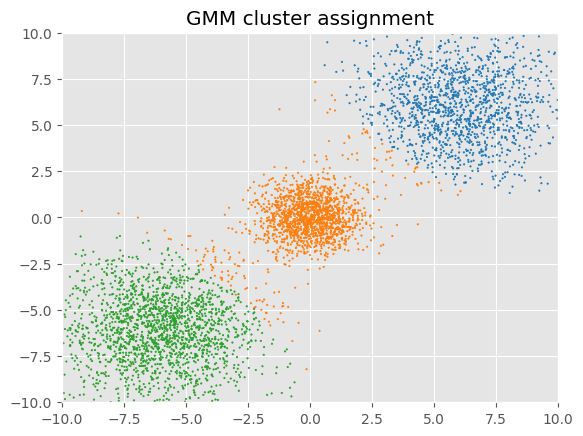

In [145]:
cmap = plt.get_cmap('tab10')
plt.title("GMM cluster assignment")
plt.scatter(
    observations[:, 0], observations[:, 1],
    1,
    c=cmap(convert_int_elements_to_consecutive_numbers_in(cluster_assignment)))
plt.axis([-10, 10, -10, 10])
plt.show()

### Generative model

In [61]:
%autoreload
from core.sgmcmc import *
def get_gen_discrete_kernel(seed, step_size_fn, log_prob_fn, optimizer_fn, 
                        x0, mh=False, 
                        temp=1.0, preconditioner=None, 
                        cat=False, dim=None, num_cls=None):
    
    if cat:
        sampler = optimizer_fn(step_size_fn, seed, dim, num_cls,
                              preconditioner=preconditioner, mh=mh, temp=temp)
    else:
        sampler = optimizer_fn(step_size_fn, seed, 
                          preconditioner=preconditioner, mh=mh, temp=temp)
    opt_state = sampler.init(x0)
    
    def step(z, x, opt_state):
        def lp_fn(w):
            return log_prob_fn(w, x)
        
        z, opt_state = sampler.update(z, lp_fn, opt_state)
        return z, opt_state
    
    return step, opt_state

def get_gen_continuous_kernel(seed, step_size_fn, log_prob_fn, optimizer_fn,
                          x0, preconditioner=get_rmsprop_preconditioner(), momentum=0.9):
    
    sampler = optimizer_fn(step_size_fn, seed, preconditioner=preconditioner, momentum_decay=momentum)
    init_opt_state = sampler.init(x0)
    
    def step(x, z, opt_state):
        grad = jax.grad(log_prob_fn)(x, z)
        updates, opt_state = sampler.update(grad, opt_state)
        x = optax.apply_updates(x, updates)
        return x, opt_state
    
    return step, init_opt_state

In [62]:
def log_prob_z_gen(pi, mu, sigma) :
    def get_per_comp_log_p(xi, pi_k, mu_k, sigma_k):
        logp = tfd.MultivariateNormalFullCovariance(mu_k, jnp.diag(sigma_k)).log_prob(xi)
        return logp + jnp.log(pi_k + EPS)
    
    def log_prob_fn(z, x):
        logits = jax.vmap(get_per_comp_log_p, in_axes=(None, 0, 0, 0))(x, pi, mu, sigma)
        log_prob = -tf.nn._softmax_cross_entropy_with_logits(logits=logits.squeeze(), labels=z.squeeze())       
        return log_prob
    
    return log_prob_fn

def log_prob_x_gen(mu, sigma):
    
    def get_per_point_log_p(xi, zi):
        mu_k = mu[zi]
        sigma_k = sigma[zi]
        logp = tfd.MultivariateNormalFullCovariance(mu_k, jnp.diag(sigma_k)).log_prob(xi)
        return logp

    def log_prob_fn(x, z):
        log_probs = get_per_point_log_p(x, z[0])
        return jnp.sum(log_probs)

    return log_prob_fn

In [63]:
from utils.nn_util import make_cyclical_cosine_lr_schedule

def gibbs_sampler_gen(*, seed, step_sizes, num_components,
                    pi, mu, sigma, 
                    n_iters=10000, burn_in=1000):
    
    rng = random.PRNGKey(seed)
    init_key, key = random.split(rng, 2)
    
    z_key, x_key = jax.random.split(init_key, 2)
    
    z0 = tfd.Categorical(probs=pi).sample(seed=z_key, sample_shape=(1,))
    x0 = random.uniform(x_key, shape=(1, mu.shape[1]), minval=-9, maxval=9)
    z_log_prob_fn = log_prob_z_gen(pi, mu, sigma)
    x_log_prob_fn = log_prob_x_gen(mu, sigma)
    
    # z_step_size = make_cyclical_cosine_lr_schedule(step_sizes["z"], n_iters, 10)
    z_kernel, z_opt_state = get_gen_discrete_kernel(seed, optax.constant_schedule(step_sizes["z"]), z_log_prob_fn,
                                   disc_cat_sgld_gradient_update, z0[:,None], 
                                   dim=1, num_cls=num_components, cat=True, mh=True)
    z_kernel = jax.jit(z_kernel)
    x_kernel, x_opt_state = get_continuous_kernel(seed, optax.constant_schedule(step_sizes["x"]), x_log_prob_fn,
                                      sgld_gradient_update, x0)
    x_kernel = jax.jit(x_kernel)
   
    state = {"z": z0, "x": x0}
    samples = {k: [] for k in state.keys()}
    
    for k, v in state.items():
        samples[k].append(v)
        
    for i in tqdm(range(n_iters)):
        z, z_opt_state = z_kernel(state["z"][:,None], state["x"], z_opt_state)
        z = z[:,0]
        x, x_opt_state = x_kernel(state["x"], state["z"], x_opt_state)
        state = {"z": z, "x": x}
        if i > burn_in:
            for k, v in state.items():
                samples[k].append(v)
        
    return samples

In [69]:
pi = jnp.array([0.4, 0.3, 0.3])
k = len(weights)
dim = 2
mu = jnp.array([[-4., -4.],
                 [0., 0.],
                 [4., 4.]])
sigma = jnp.ones((k, dim)) # variance set to one
step_sizes = {"z": 0.8, "x": 0.1}
gmm_samples = gibbs_sampler_gen(seed=0, step_sizes=step_sizes, 
                        num_components=k, pi=pi, mu=mu, sigma=sigma,
                        n_iters=20000, burn_in=1000)

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:07<00:00, 2648.91it/s]


In [70]:
frequency = []
total_samples = len(gmm_samples["z"])
for i in range(len(weights)):
    class_i_samples = jnp.sum(np.array(gmm_samples["z"]) == jnp.array([i]))
    frequency.append(class_i_samples/total_samples)
    
print(frequency)

[Array(0.3106842, dtype=float32), Array(0.2391579, dtype=float32), Array(0.45015788, dtype=float32)]


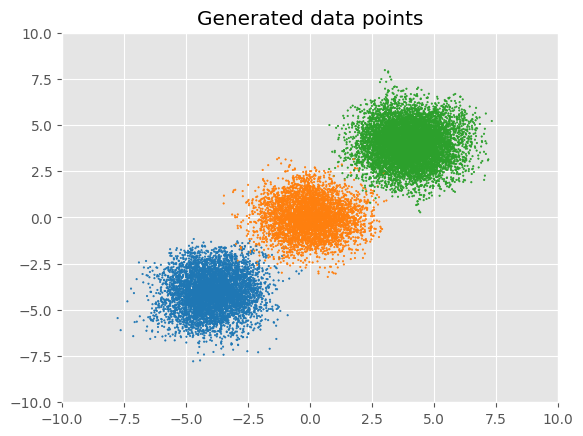

In [73]:
x_samples = np.array(gmm_samples["x"]).squeeze()
cluster_assignment = convert_int_elements_to_consecutive_numbers_in(np.array(gmm_samples["z"]))
plt.title("Generated data points")
plt.scatter(x_samples[:,0], x_samples[:,1], 
            1, c=cmap(convert_int_elements_to_consecutive_numbers_in(cluster_assignment)))
plt.axis([-10, 10, -10, 10])
plt.show()

In [75]:
x_samples.shape

(19000, 2)

In [76]:
tfp.mcmc.effective_sample_size(x_samples, filter_beyond_positive_pairs=True)

Array([6.467469, 6.523377], dtype=float32)